In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.dataset import *
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

## Load and clean data

In [4]:
PATH = '../input'
TRAIN = '../input/train/'
TEST = '../input/test/'
SEGMENTATION = '../input/train_ship_segmentations.csv'
PRETRAINED = '../input/fine-tuning-resnet34-on-ship-detection/models/Resnet34_lable_256_1.h5'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

In [5]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
print(f'{len(train_names)} images founded for training')
print(f'{len(test_names)} images founded for testing')

img_df = pd.read_csv(os.path.join(PATH, SEGMENTATION))

img_df.drop(img_df[img_df['ImageId']=='6384c3e78.jpg'].index,inplace = True)
img_df['ships'] = img_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

img_ship = img_df.groupby('ImageId').agg({'ships': 'sum'})
print(f'Out of {len(train_names)} training images, only {len(img_ship.drop(img_ship.ships[img_ship.ships==0].index))} images that has ships')

104069 images founded for training
88486 images founded for testing
Out of 104069 training images, only 29070 images that has ships


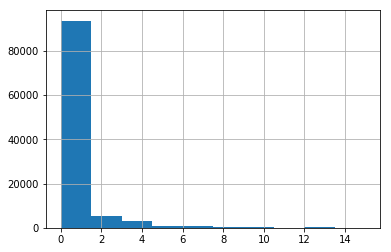

In [6]:
img_ship.ships.hist()

## Create a label for all images

In [7]:
img_label = pd.DataFrame()
img_label['has_ships'] = img_ship['ships'].apply(lambda x: 0 if x == 0 else 1)

## Down sample from no ships

In [8]:
SAMPLES_PER_GROUP = len(img_ship.drop(img_ship.ships[img_ship.ships==0].index))
balanced_img_label = img_label.groupby('has_ships', group_keys=False).apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)

In [9]:
def show_from_df(ind_list):
    for ind in ind_list:
        plt.figure(figsize=(5,5))
        im = plt.imread(f'{TRAIN}/{balanced_img_label.index[ind]}')
        label =  balanced_img_label.loc[balanced_img_label.index[ind],'has_ships']
        plt.imshow(im)
        text_label = ['no ship','has ship']
        plt.title(text_label[label])

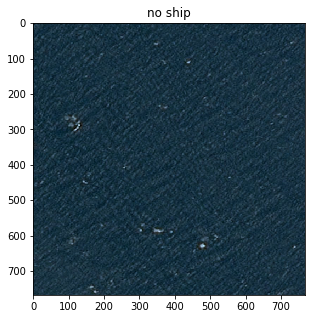

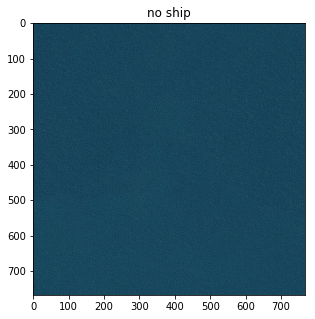

In [10]:
show_from_df(list(np.random.randint(1000, size=2)))

## Data augmentation

In [12]:
def rand0(s): return random.random()*(s*2)-s

In [61]:
class RandomRotate(CoordTransform):
    """ Rotates images and (optionally) target y.
    Rotating coordinates is treated differently for x and y on this
    transform.
     Arguments:
        deg (float): degree to rotate.
        p (float): probability of rotation
        mode: type of border
        tfm_y (TfmType): type of y transform
    """
    def __init__(self, deg, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.deg,self.p = deg,p
        if tfm_y == TfmType.COORD or tfm_y == TfmType.CLASS:
            self.modes = (mode,cv2.BORDER_CONSTANT)
        else:
            self.modes = (mode,mode)

    def set_state(self):
        self.store.rdeg = rand0(self.deg)
        self.store.rp = random.random()<self.p

    def do_transform(self, x, is_y):
        if self.store.rp: 
            rotated = rotate_bound2(x, self.store.rdeg) 
        else: 
            rotated = x
        return cv2.resize(rotated, x.shape[:2], interpolation=cv2.INTER_AREA)

In [44]:
def rotate_bound2(image, angle, mode=cv2.BORDER_DEFAULT, interpolation=cv2.INTER_AREA):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [95]:
arch=resnext50
sz = 512
bs = 8

def get_augs(n):
    aug_tfms = [RandomRotate(180),RandomDihedral(),RandomLighting(0.05, 0.05),RandomStretch(max_stretch=1.05),
                Cutout(n_holes=10, length=0.02*sz)]
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',tfms=tfms, bs=bs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[n]

In [67]:
def plots(ims, figsize=(18,12), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

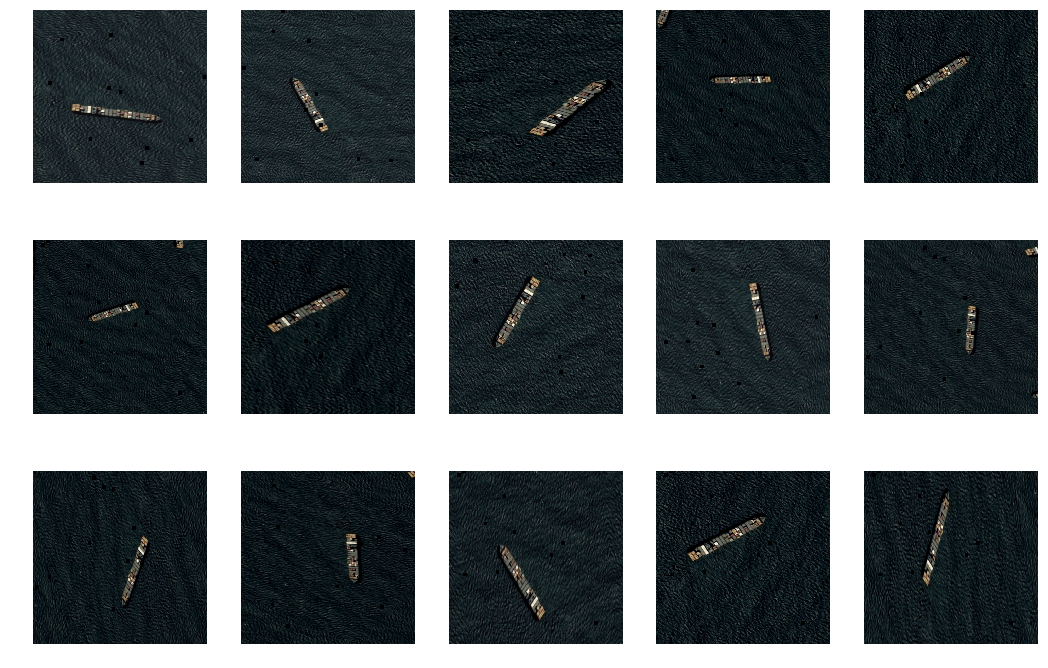

In [96]:
ims = np.stack([get_augs(1) for i in range(15)])
plots(ims, rows=3)

## Train the classifier

In [437]:
balanced_img_label.to_csv(f'{PATH}/labels.csv')

In [438]:
def get_data(sz, bs): # sz: image size, bs: batch size
    aug_tfms = [RandomRotate(180),RandomDihedral(),RandomLighting(0.05, 0.05),RandomStretch(max_stretch=1.05),
                Cutout(n_holes=10, length=0.02*sz)]
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',tfms=tfms, bs=bs)
    return data

In [439]:
arch=resnext50
sz = 128
bs = 8
data = get_data(sz, bs)

In [441]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

#lrf=learn.lr_find()

  0%|          | 0/4070 [00:00<?, ?it/s]

/home/chi/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/chi/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 1018/1018 [02:53<00:00,  5.87it/s]


 60%|██████    | 2448/4070 [00:40<00:26, 61.20it/s, loss=1.46] 

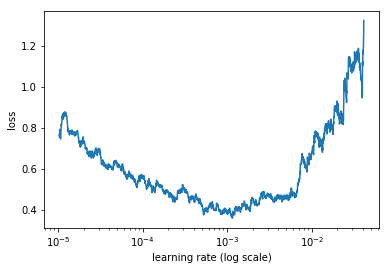

In [442]:
learn.sched.plot()

In [257]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lr = 4e-3
learn.fit(lr, 2)

/home/chi/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/chi/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   accuracy                       
    0      0.410868   0.290696   0.878609  
    1      0.388932   0.267061   0.893107                       


[0.2670605025113559, 0.8931072613343163]

In [258]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.344838   0.280357   0.896425  
    1      0.370852   0.287391   0.899128                      
    2      0.395873   0.269621   0.901216                      


[0.26962138247557305, 0.9012163656468853]

In [260]:
learn.unfreeze()
learn.bn_freeze(True)

lrs=np.array([lr/9,lr/3,lr])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# put on cluster 
# change size 
# change batch size
# change augmentation, do more augmentaiton 
# train more epocs 

## Visualize the prediction results

### Decoding the mask

In [295]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [264]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

log_preds[:10]

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [421]:
# def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
# def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims,masks, figsize=(2,4), rows=4, titles=None):
    f, axes = plt.subplots(rows, 2, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i%2 == 0:
            ax.imshow(ims[int(i/2)])
            ax.set_title(titles[int(i/2)])
        else:
            ax.imshow(masks[int(i/2)])
            ax.set_title(titles[int(i/2)])
    plt.tight_layout()

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def load_mask_fname(fname):
    img = plt.imread(f'{TRAIN}/{fname}')
    rle = img_df.loc[img_df['ImageId']==fname,'EncodedPixels'].values
    if ~pd.isna(rle.any()):
        img_c = masks_as_color(rle)
    else:
        img_c = np.ones(img.shape)
    return img_c


def plot_val_with_title(idxs, title,figsize = (8,16)):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    masks = [load_mask_fname(data.val_ds.fnames[x][6:]) for x in idxs]
    title_probs = ['prob: '+"{0:.3f}".format(probs[x]) for x in idxs]
    print(title)
    return plots(imgs,masks, rows=len(idxs), titles=title_probs, figsize=(8,16)) if len(imgs)>0 else print('Not Found.')

# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [403]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct, has ships:True postive


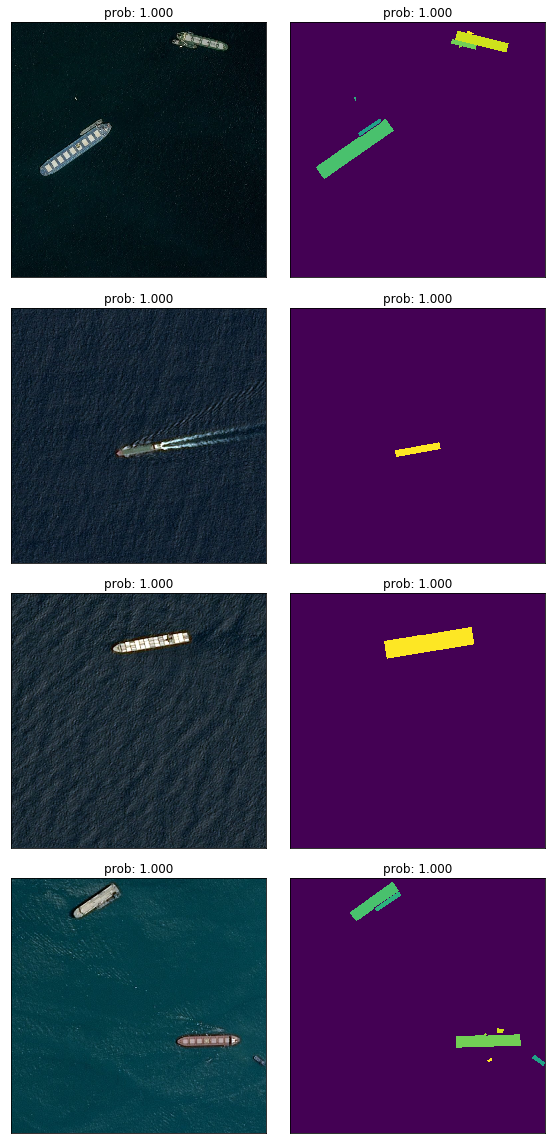

In [422]:
plot_val_with_title(most_by_correct(1, True), "Most correct, has ships:True postive")

Most correct, no ships:False negtive


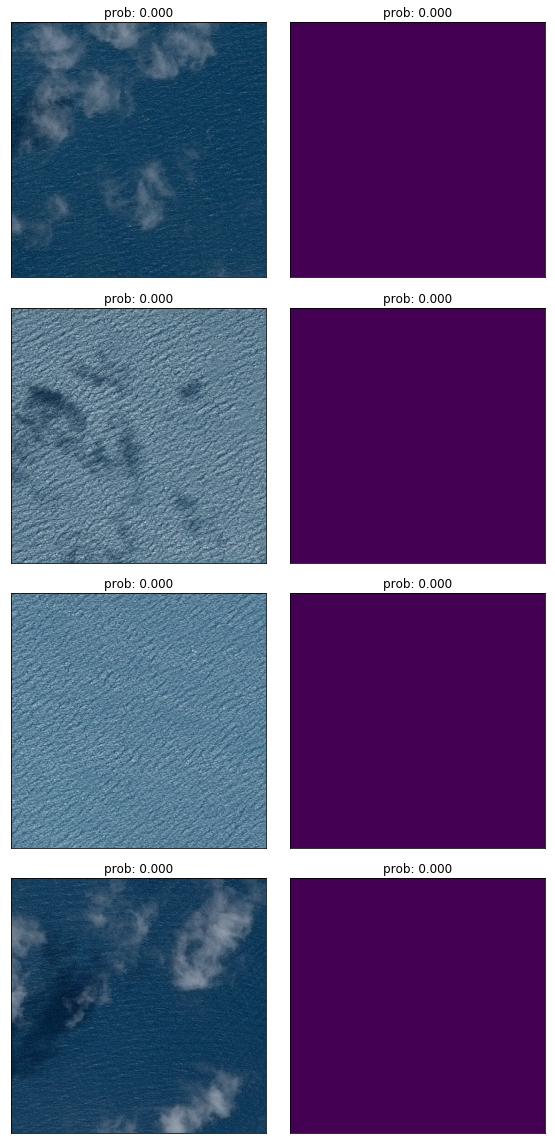

In [423]:
plot_val_with_title(most_by_correct(0, True), "Most correct, no ships:False negtive")

Most wrong, has ships but predict no ship:True negtive


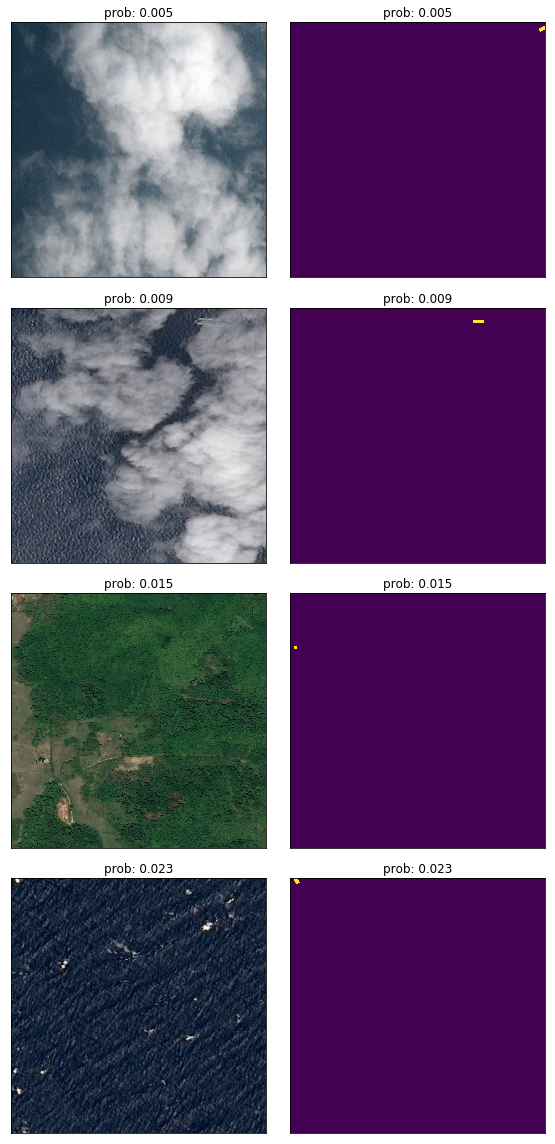

In [424]:
plot_val_with_title(most_by_correct(1, False), "Most wrong, has ships but predict no ship:True negtive")

Most wrong, no ships but predict has ship: False positive


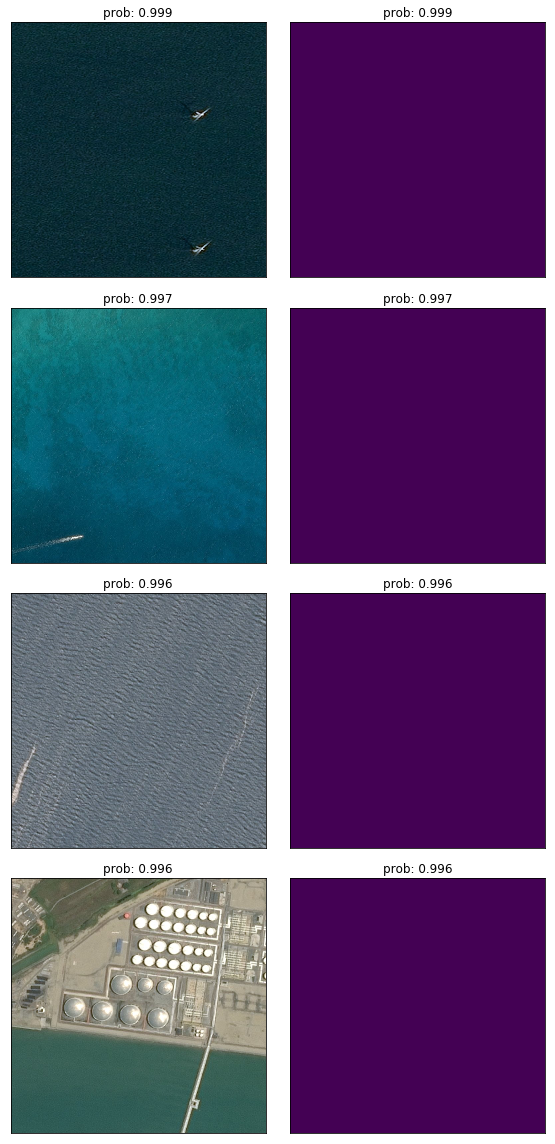

In [425]:
plot_val_with_title(most_by_correct(0, False), "Most wrong, no ships but predict has ship: False positive")

Most uncertain predictions


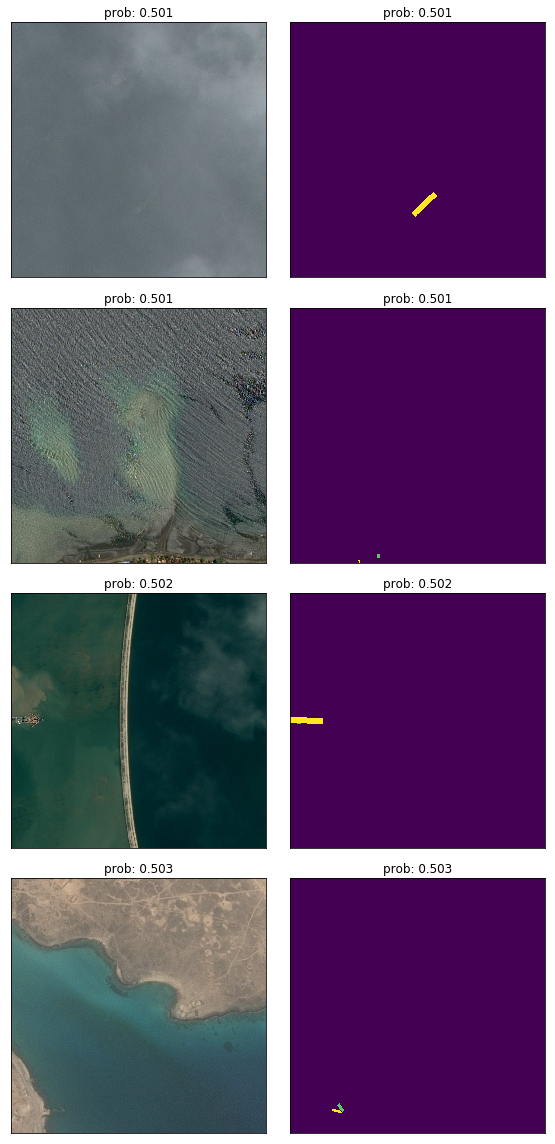

In [426]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")